<a href="https://colab.research.google.com/github/Rahadiyan-ML44/SkAnner-Bangkit22CP/blob/main/Melanoma_MobNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.layers.experimental.preprocessing as tflpp

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import sparse_categorical_accuracy, sparse_top_k_categorical_accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LABELS**<br>

Excerpts from Dermnet:<br>
> The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set. <br>

Taken only the melanoma folder in train and test zip. Manually categorized by type.<br>


 **a-nev**<br>
 Atypical nevi on skin and trunk (human torso).<br>
 *[121 images]*
 
 **bck-nev**<br>
 Becker nevus.<br>
 *[29 images]*
  
**bl-nev**<br>
 Blue nevus.<br>
*[24 images]*

**con-nev**<br>
Congenital nevus.<br>
*[55 images]*
 
**hal-nev**<br>
Halo nevus.<br>
*[31 images]*

**len-mal**<br>
Lentigo malignant.<br>
*[29 images]*

**mal-mel**<br>
Malignant melanoma.<br>
*[130 images]*

**mela-nev-mac**<br>
Melanocytic nevi and macule.<br>
*[109 images]*

**mong-spot**<br>
Mongolian spot.<br>
*[4 images]*

**nev-re-spi**<br>
Nevus repigment and spilus.<br>
*[36 images]*

**spi-nev**<br>
Spitz's nevus.<br>
*[11 images]*

<br>*[Total images = 579]*

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/drive/MyDrive/GColab2/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 579 files belonging to 11 classes.
Using 464 files for training.
Found 579 files belonging to 11 classes.
Using 115 files for validation.


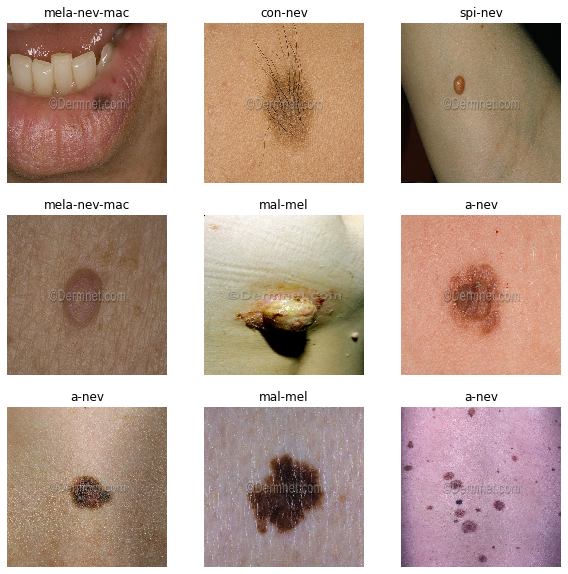

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
                                             tflpp.RandomFlip("horizontal"),
                                             tflpp.RandomRotation(0.2),
                                             tflpp.RandomHeight(0.1),
                                             tflpp.RandomWidth(0.1),
                                             tflpp.RandomZoom(0.2),
                                             ])
    
    return data_augmentation

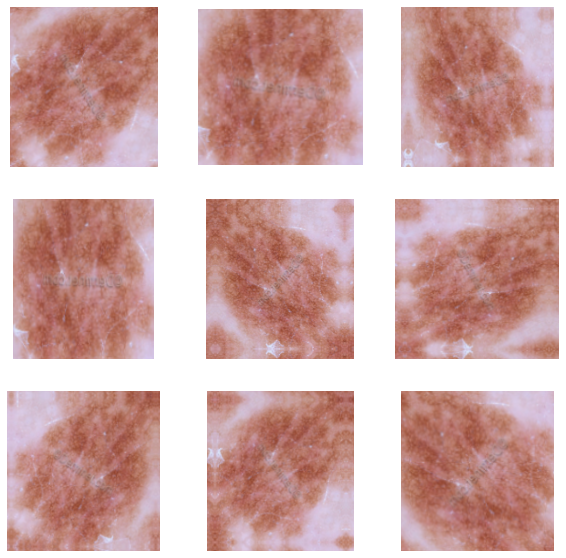

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# **Importing Base Model**

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([4, 0, 0, 6, 7, 6, 5, 0, 7, 7, 6, 3, 3, 0, 6, 7, 8, 2, 5, 0, 2, 4,
       3, 0, 6, 6, 9, 9, 2, 0, 1, 7], dtype=int32)>

# **Modifying Base Model and Preparing for Training**

In [ ]:
def melanoma_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
  input_shape = image_shape + (3,)

  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                 include_top=False
                                                 )
  
  # for layer in base_model.layers[:-30]:
  #   layer.trainable = False
    
  base_model.trainable=False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tfl.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(.2)(x)
  x = tfl.Flatten()(x)
  prediction_layer = tf.keras.layers.Dense(11, activation='softmax')
    
  outputs = prediction_layer(x) 
  model = tf.keras.Model(inputs, outputs)
    
  return model

In [ ]:
model2 = melanoma_model(IMG_SIZE, data_augmentation)

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

# **Initial Training**

In [ ]:
def st_2_accuracy(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

def st_3_accuracy(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)


In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[sparse_categorical_accuracy, st_2_accuracy, st_3_accuracy])

In [ ]:
initial_epochs = 10
history = model2.fit(train_dataset,
                     validation_data=validation_dataset,
                     epochs=initial_epochs,
                     verbose=1)

Epoch 1/10
15/15 [==============================] - 12s 557ms/step - loss: 2.4074 - sparse_categorical_accuracy: 0.2759 - st_2_accuracy: 0.4677 - st_3_accuracy: 0.5668 - val_loss: 2.0624 - val_sparse_categorical_accuracy: 0.2696 - val_st_2_accuracy: 0.4522 - val_st_3_accuracy: 0.6000
Epoch 2/10
15/15 [==============================] - 9s 519ms/step - loss: 1.7673 - sparse_categorical_accuracy: 0.4267 - st_2_accuracy: 0.5991 - st_3_accuracy: 0.7284 - val_loss: 1.7580 - val_sparse_categorical_accuracy: 0.3913 - val_st_2_accuracy: 0.5391 - val_st_3_accuracy: 0.6696
Epoch 3/10
15/15 [==============================] - 9s 518ms/step - loss: 1.5348 - sparse_categorical_accuracy: 0.4957 - st_2_accuracy: 0.6724 - st_3_accuracy: 0.7759 - val_loss: 1.5818 - val_sparse_categorical_accuracy: 0.4261 - val_st_2_accuracy: 0.5652 - val_st_3_accuracy: 0.7217
Epoch 4/10
15/15 [==============================] - 9s 536ms/step - loss: 1.2455 - sparse_categorical_accuracy: 0.5711 - st_2_accuracy: 0.7306 - st

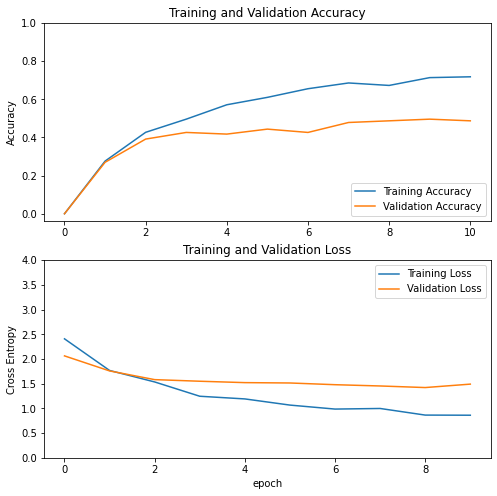

In [ ]:
acc = [0.] + history.history['sparse_categorical_accuracy']
val_acc = [0.] + history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Fine Tuning**

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  156


In [ ]:
fine_tune_at = 130

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer= tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
metrics=[sparse_categorical_accuracy, st_2_accuracy, st_3_accuracy]

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                          validation_data=validation_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         )

Epoch 10/15
15/15 [==============================] - 12s 560ms/step - loss: 0.8209 - sparse_categorical_accuracy: 0.7177 - st_2_accuracy: 0.8642 - st_3_accuracy: 0.9332 - val_loss: 1.4331 - val_sparse_categorical_accuracy: 0.4957 - val_st_2_accuracy: 0.6783 - val_st_3_accuracy: 0.7913
Epoch 11/15
15/15 [==============================] - 9s 488ms/step - loss: 0.7985 - sparse_categorical_accuracy: 0.7328 - st_2_accuracy: 0.8901 - st_3_accuracy: 0.9418 - val_loss: 1.4120 - val_sparse_categorical_accuracy: 0.4870 - val_st_2_accuracy: 0.6783 - val_st_3_accuracy: 0.7913
Epoch 12/15
15/15 [==============================] - 8s 524ms/step - loss: 0.7998 - sparse_categorical_accuracy: 0.7241 - st_2_accuracy: 0.8987 - st_3_accuracy: 0.9353 - val_loss: 1.4160 - val_sparse_categorical_accuracy: 0.4783 - val_st_2_accuracy: 0.6870 - val_st_3_accuracy: 0.8000
Epoch 13/15
15/15 [==============================] - 8s 490ms/step - loss: 0.7967 - sparse_categorical_accuracy: 0.6961 - st_2_accuracy: 0.8922 

In [ ]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

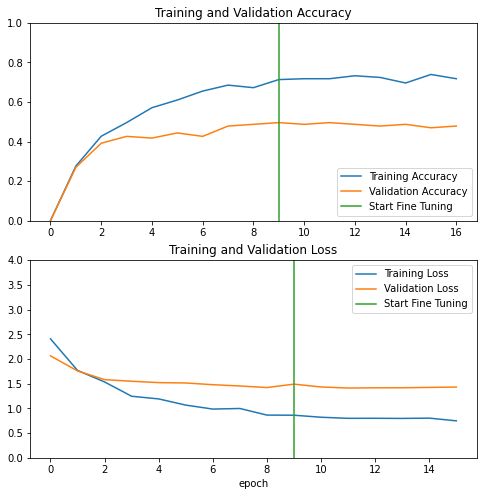

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Making the TensorFlow.js Model**

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# create a directory to store the model files
os.mkdir('tfjs_dir')

# convert to Tensorflow.js
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model2, 'tfjs_dir')

In [ ]:
# check the the directory containing the model is available
!ls

drive  sample_data  tfjs_dir


In [ ]:
# view the files that make up the tensorflow.js model
os.listdir('tfjs_dir')

['group1-shard3of3.bin',
 'group1-shard1of3.bin',
 'model.json',
 'group1-shard2of3.bin']

# **References**


---

Skin-Lesion-Analyzer by vbookshelf<br>
https://github.com/vbookshelf/Skin-Lesion-Analyzer<br><br>

Transfer Learning with MobileNetV2 by EhabR98<br>
https://github.com/EhabR98/Transfer-Learning-with-MobileNetV2<br><br>

Skin Diseases Classification by Mediano Sandie<br>
https://www.kaggle.com/code/medianosandie/skin-diseases-classification/notebook<br><br>

Dermnet by Shubham Goel & Bill Hall<br>
https://www.kaggle.com/datasets/shubhamgoel27/dermnet?resource=download&select=train